# Pythonによるプログラムコード

## 導入

In [1]:
import sys
import numpy as np
import pandas as pd
import scipy as sp
from scipy.integrate import odeint
import lmfit
from lmfit import minimize, Parameters, report_fit
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import sklearn
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import japanize_matplotlib
import json
import datetime
import warnings 
np.set_printoptions(threshold=0)
warnings.filterwarnings("ignore")

print('Python version: {}'.format(sys.version))
print('NumPy version: {}'.format(np.__version__))
print('pandas version: {}'.format(pd.__version__))
print('SciPy version: {}'.format(sp.__version__))
print('LMFIT version: {}'.format(lmfit.__version__))
print('statsmodels version: {}'.format(sm.__version__))
print('sklearn version: {}'.format(sklearn.__version__))
print('matplotlib version: {}'.format(matplotlib.__version__))

Python version: 3.7.9 (default, Aug 31 2020, 07:22:35) 
[Clang 10.0.0 ]
NumPy version: 1.19.2
pandas version: 1.1.5
SciPy version: 1.5.2
LMFIT version: 1.0.1
statsmodels version: 0.12.1
sklearn version: 0.23.2
matplotlib version: 3.3.2


/opt/anaconda3/lib/python3.7/site-packages/japanize_matplotlib/japanize_matplotlib.py:15: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = font_manager.createFontList(font_files)


----------------------------------

## 感染者データの可視化

In [2]:
world_data = pd.read_csv('https://covid.ourworldindata.org/data/owid-covid-data.csv',parse_dates=True)
world_data = world_data[['date','continent','location','total_cases','new_cases','total_deaths','new_deaths']].set_index('date')

continents = ['Asia', 'Europe', 'Africa', 'North America', 'South America', 'Oceania']
date_range = pd.date_range(world_data.sort_index().index[0],
                           world_data.sort_index().index[-1],
                           freq='d')

res_t_cases = pd.DataFrame(index=continents, columns=date_range)
res_t_deaths = pd.DataFrame(index=continents, columns=date_range)

for i in continents:
    subset = world_data[world_data['continent'] == i]
    date = pd.date_range(subset.sort_index().index[0],subset.sort_index().index[-1],freq='d')
    for j in date:
        datetime = j.strftime('%Y-%m-%d')
        subsubset = subset[subset.index.str.contains(datetime)]
        res_t_cases.at[i,j] = subsubset['total_cases'].sum()
        res_t_deaths.at[i,j] = subsubset['total_deaths'].sum()

res_n_cases = pd.DataFrame(index=date_range, columns=['new_cases'])
res_n_deaths = pd.DataFrame(index=date_range, columns=['new_deaths'])

for k in date_range:
    datetime = k.strftime('%Y-%m-%d')
    subset = world_data[world_data.index.str.contains(datetime)]
    res_n_cases.at[k,'new_cases'] = subset['new_cases'].sum()
    res_n_deaths.at[k,'new_deaths'] = subset['new_deaths'].sum()

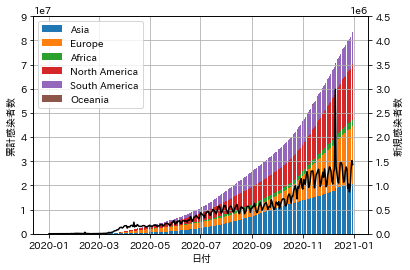

In [3]:
fig, ax1 = plt.subplots(1,1)
ax2 = ax1.twinx()
for i in range(len(res_t_cases)):
    ax1.bar(res_t_cases.columns, res_t_cases.iloc[i], bottom=res_t_cases.iloc[:i].sum())
ax1.set(xlabel='日付', ylabel='累計感染者数')
ax1.legend(res_t_cases.index, loc=2)
ax2.plot(res_n_cases['new_cases'],linestyle='solid',color='k')
ax2.set(ylabel='新規感染者数')
ax1.set_ylim(0,9e+7)
ax2.set_ylim(0,4.5e+6)
ax1.grid()
fig.savefig('figure/globalcases.pdf', bbox_inches='tight')
fig.show()

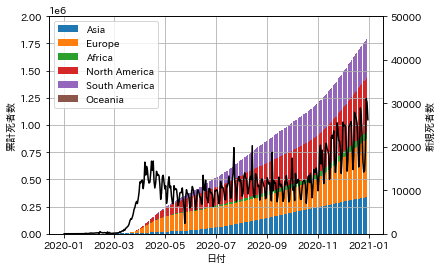

In [4]:
fig, ax1 = plt.subplots(1,1)
ax2 = ax1.twinx()
for i in range(len(res_t_deaths)):
    ax1.bar(res_t_deaths.columns, res_t_deaths.iloc[i], bottom=res_t_deaths.iloc[:i].sum())
ax1.set(xlabel='日付', ylabel='累計死者数')
ax1.legend(res_t_deaths.index, loc=2)
ax2.plot(res_n_deaths['new_deaths'],linestyle='solid',color='k')
ax2.set(ylabel='新規死者数')
ax1.set_ylim(0,2e+6)
ax2.set_ylim(0,50000)
ax1.grid()
fig.savefig('figure/globaldeaths.pdf', bbox_inches='tight')
fig.show()

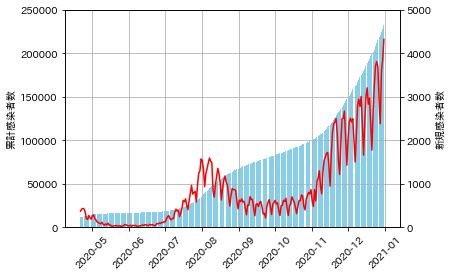

In [5]:
japan_data = pd.read_json('https://data.corona.go.jp/converted-json/covid19japan-npatients.json', dtype='float')
japan_data = japan_data.set_index('date')

fig, ax1 = plt.subplots(1,1)
ax2 = ax1.twinx()
ax1.bar(japan_data.index, japan_data['npatients'], color='skyblue')
ax1.set_xticklabels('日付', rotation=45)
ax1.set_ylabel('累計感染者数')
ax2.plot(japan_data['adpatients'],linestyle='solid',color='r')
ax2.set(ylabel='新規感染者数')
ax1.set_ylim(0,250000)
ax2.set_ylim(0,5000)
ax1.grid()
fig.savefig('figure/japancases.pdf', bbox_inches='tight')
fig.show()

-------------------------------------

## SIRモデル

### SIRモデルのシミュレーション

In [6]:
def SIR_model(z, t, beta, gamma):
    S, I, R = z
    N = S + I + R
    dSdt = -beta*S*I/N
    dIdt = beta*S*I/N - gamma*I
    dRdt = gamma*I
    return [dSdt, dIdt, dRdt]

In [7]:
tspan = np.arange(0, 100)
initI, initR, initN = 100, 0, 120000000
initS = initN - (initI + initR)
beta, gamma = 0.5, 0.1

result = odeint(SIR_model, [initS, initI, initR], tspan, args=(beta, gamma))
result

array([[1.19999900e+08, 1.00000000e+02, 0.00000000e+00],
       [1.19999839e+08, 1.49182390e+02, 1.22956142e+01],
       [1.19999747e+08, 2.22553785e+02, 3.06385026e+01],
       ...,
       [8.49283849e+05, 3.30251480e+05, 1.18820465e+08],
       [8.48170520e+05, 2.99882506e+05, 1.18851947e+08],
       [8.47160837e+05, 2.72304971e+05, 1.18880534e+08]])

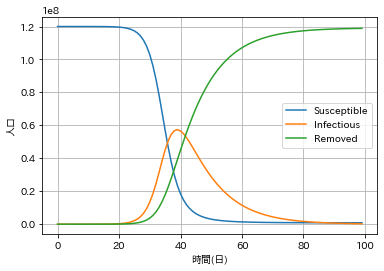

In [8]:
plt.plot(tspan, result)
plt.legend(['Susceptible', 'Infectious', 'Removed'])
plt.xlabel('時間(日)')
plt.ylabel('人口')
plt.grid()
plt.savefig('figure/SIRsimu.pdf')
plt.show()

### SIRモデルのパラメータ推定

In [9]:
patients = pd.read_json('https://data.corona.go.jp/converted-json/covid19japan-npatients.json', dtype='float')
recovery = pd.read_csv('https://www.mhlw.go.jp/content/recovery_total.csv', index_col='日付' , dtype='float', parse_dates=True)
death = pd.read_csv('https://www.mhlw.go.jp/content/death_total.csv', index_col='日付' , dtype='float', parse_dates=True)

cml_df = patients.set_index('date').drop(columns='adpatients').rename(columns={'npatients':'infected'})
cml_df['removed'] = recovery['退院、療養解除となった者']+death['死亡者数']
cml_df = cml_df['2020-05-08':]
cml_df = cml_df.dropna(how = 'any')
print(cml_df)

            infected   removed
date                          
2020-05-08   15462.0    8710.0
2020-05-09   15581.0    8889.0
2020-05-10   15630.0    9135.0
2020-05-11   15706.0    9546.0
2020-05-12   15854.0   10519.0
...              ...       ...
2020-12-27  218374.0  186198.0
2020-12-28  221246.0  188528.0
2020-12-29  224716.0  191087.0
2020-12-30  228418.0  193108.0
2020-12-31  232495.0  195408.0

[238 rows x 2 columns]


In [10]:
def SIR_solver(t, initial_conditions, params):
    initI, initR, initN = initial_conditions
    beta, gamma = params['beta'].value, params['gamma'].value
    initS = initN - (initI + initR)
    res = odeint(SIR_model, [initS, initI, initR], t, args=(beta, gamma))
    return res

In [11]:
def error(params, initial_conditions, tspan, data):
    sol = SIR_solver(tspan, initial_conditions, params)
    return (sol[:, 1:3] - data).ravel()

In [12]:
initN = 126500000
initI = cml_df.at[cml_df.index[0], 'infected']
initR = cml_df.at[cml_df.index[0], 'removed']
initial_conditions = [initI, initR, initN]

period = cml_df.index[-1]-cml_df.index[0]
days = period.days
tspan = np.arange(0, days+1)

data = cml_df[['infected','removed']].values
data

array([[ 15462.,   8710.],
       [ 15581.,   8889.],
       [ 15630.,   9135.],
       ...,
       [224716., 191087.],
       [228418., 193108.],
       [232495., 195408.]])

In [13]:
params = Parameters()
params.add('beta', value=beta, min=0, max=10)
params.add('gamma', value=gamma, min=0, max=10)
params['beta'].value = 0.5
params['gamma'].value = 0.1

In [14]:
result = minimize(error, params, args=(initial_conditions, tspan, data))
report_fit(result)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 32
    # data points      = 476
    # variables        = 2
    chi-square         = 2.7129e+10
    reduced chi-square = 57233975.4
    Akaike info crit   = 8504.62112
    Bayesian info crit = 8512.95195
[[Variables]]
    beta:   0.02133233 +/- 6.7510e-05 (0.32%) (init = 0.5)
    gamma:  0.01022004 +/- 7.5974e-05 (0.74%) (init = 0.1)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, gamma) =  0.939


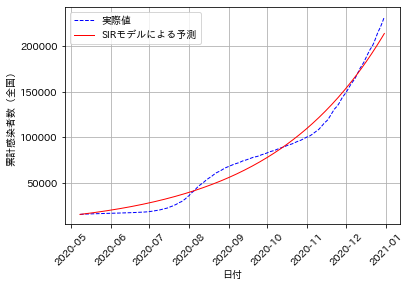

In [15]:
SIR_pred = data + result.residual.reshape(data.shape)
SIR_pred = pd.DataFrame(SIR_pred)
SIR_pred['date'] = pd.date_range(start=cml_df.index[0],end=cml_df.index[-1], freq='D')
SIR_pred = SIR_pred.set_index('date')

plt.plot(cml_df['infected'], color='blue',  linestyle='dashed', linewidth = 1.0, label='実際値')
plt.plot(SIR_pred[0], color='red',  linestyle='solid', linewidth = 1.0, label='SIRモデルによる予測')
plt.xlabel('日付')
plt.ylabel('累計感染者数（全国）')
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.savefig('figure/SIRest.pdf', bbox_inches='tight')
plt.show()

--------------------------------------------------------------------

## SARIMAモデル

### データの読込・成分分解

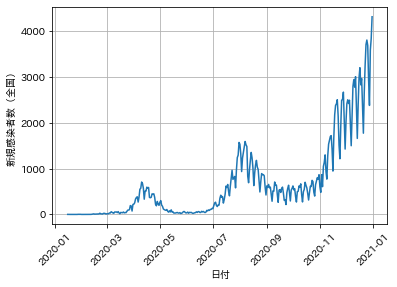

In [16]:
new_df = pd.read_csv('https://www.mhlw.go.jp/content/pcr_positive_daily.csv', index_col='日付' , dtype='float', parse_dates=True)

plt.plot(new_df)
plt.xlabel('日付')
plt.ylabel('新規感染者数（全国）')
plt.grid()
plt.xticks(rotation=45)
plt.savefig('figure/newinfected.pdf', bbox_inches='tight')
plt.show()

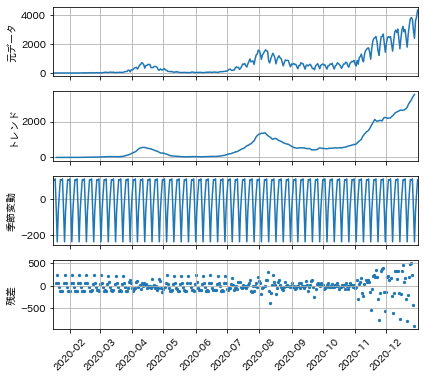

In [17]:
decomposition = seasonal_decompose(new_df, period=7)

fig = plt.figure(figsize=(6, 5))

t = pd.date_range(new_df.index[0],new_df.index[-1])

ax1 = fig.add_subplot(4, 1, 1)
ax2 = fig.add_subplot(4, 1, 2)
ax3 = fig.add_subplot(4, 1, 3)

ax1.plot(t, new_df)
ax2.plot(t, decomposition.trend)
ax3.plot(t, decomposition.seasonal)

axs = plt.gcf().get_axes()
for ax in axs:
    ax.axes.get_xaxis().set_ticklabels([])

ax4 = fig.add_subplot(4, 1, 4)
ax4.scatter(t, decomposition.resid, s=5)

axs = plt.gcf().get_axes()
for ax in axs:
    ax.set_xlim(new_df.index[0],new_df.index[-1])
    ax.grid()
    
ax1.set_ylabel('元データ')
ax2.set_ylabel('トレンド')
ax3.set_ylabel('季節変動')
ax4.set_ylabel('残差')

fig.tight_layout()
plt.xticks(rotation=45)
plt.savefig('figure/SeaDec.pdf', bbox_inches='tight')
plt.show()

### SARIMAモデルのパラメータ推定

In [18]:
max_p = 3
max_q = 3
max_d = 1
max_sp = 1
max_sq = 1
max_sd = 1

pattern = max_p*(max_q + 1)*(max_d + 1)*(max_sp + 1)*(max_sq + 1)*(max_sd + 1)

modelSelection = pd.DataFrame(index=range(pattern), columns=["model", "aic"])
pattern

192

In [19]:
num = 0
for p in range(1, max_p + 1):
    for d in range(0, max_d + 1):
        for q in range(0, max_q + 1):
            for sp in range(0, max_sp + 1):
                for sd in range(0, max_sd + 1):
                    for sq in range(0, max_sq + 1):
                        sarima = sm.tsa.SARIMAX(new_df, order=(p,d,q), seasonal_order=(sp,sd,sq,7), enforce_stationarity = True, enforce_invertibility = True).fit(method='bfgs', maxiter=300, disp=False)
                        print("order=(" + str(p) + ","+ str(d) + ","+ str(q) + "), season=("+ str(sp) + ","+ str(sd) + "," + str(sq) + "), AIC=" + str(sarima.aic))
                        modelSelection.iloc[num]["model"] = "order=(" + str(p) + ","+ str(d) + ","+ str(q) + "), season=("+ str(sp) + ","+ str(sd) + "," + str(sq) + ")"
                        modelSelection.iloc[num]["aic"] = sarima.aic
                        num = num + 1

order=(1,0,0), season=(0,0,0), AIC=4789.6741815771675
order=(1,0,0), season=(0,0,1), AIC=4640.988814376798
order=(1,0,0), season=(0,1,0), AIC=4364.919551531413
order=(1,0,0), season=(0,1,1), AIC=4312.23604128839
order=(1,0,0), season=(1,0,0), AIC=4461.515579512793
order=(1,0,0), season=(1,0,1), AIC=4416.190204821394
order=(1,0,0), season=(1,1,0), AIC=4319.342659526765
order=(1,0,0), season=(1,1,1), AIC=4313.692999168856
order=(1,0,1), season=(0,0,0), AIC=4774.505956790559
order=(1,0,1), season=(0,0,1), AIC=4640.811151456082
order=(1,0,1), season=(0,1,0), AIC=4366.536668461486
order=(1,0,1), season=(0,1,1), AIC=4313.876437277307
order=(1,0,1), season=(1,0,0), AIC=4462.40490052502
order=(1,0,1), season=(1,0,1), AIC=4417.991021213583
order=(1,0,1), season=(1,1,0), AIC=4321.310025836585
order=(1,0,1), season=(1,1,1), AIC=4315.44602079781
order=(1,0,2), season=(0,0,0), AIC=5527.460194819838
order=(1,0,2), season=(0,0,1), AIC=4598.845611347036
order=(1,0,2), season=(0,1,0), AIC=4357.58018222

order=(3,0,3), season=(0,1,1), AIC=4325.825061194029
order=(3,0,3), season=(1,0,0), AIC=4649.254360506154
order=(3,0,3), season=(1,0,1), AIC=4706.496969699118
order=(3,0,3), season=(1,1,0), AIC=4327.788059768667
order=(3,0,3), season=(1,1,1), AIC=4334.021287945821
order=(3,1,0), season=(0,0,0), AIC=4714.487634608428
order=(3,1,0), season=(0,0,1), AIC=4585.438066497065
order=(3,1,0), season=(0,1,0), AIC=4355.226831885752
order=(3,1,0), season=(0,1,1), AIC=4288.693345911752
order=(3,1,0), season=(1,0,0), AIC=4431.686566028595
order=(3,1,0), season=(1,0,1), AIC=4387.835743200724
order=(3,1,0), season=(1,1,0), AIC=4301.532744272632
order=(3,1,0), season=(1,1,1), AIC=4290.688439284075
order=(3,1,1), season=(0,0,0), AIC=4675.063226029293
order=(3,1,1), season=(0,0,1), AIC=4602.011068312304
order=(3,1,1), season=(0,1,0), AIC=4348.2350397106875
order=(3,1,1), season=(0,1,1), AIC=4291.126728426494
order=(3,1,1), season=(1,0,0), AIC=4523.652204797045
order=(3,1,1), season=(1,0,1), AIC=4512.42525

In [20]:
modelSelection[modelSelection.aic == min(modelSelection.aic)]

,model,aic
107,"order=(2,1,1), season=(0,1,1)",4281.92


In [21]:
bestSARIMA = sm.tsa.SARIMAX(new_df, order=(2,1,1), seasonal_order=(0,1,1,7), enforce_stationarity = True, enforce_invertibility = True).fit()
print(bestSARIMA.summary())

                                     SARIMAX Results                                     
Dep. Variable:                    PCR 検査陽性者数(単日)   No. Observations:                  351
Model:             SARIMAX(2, 1, 1)x(0, 1, 1, 7)   Log Likelihood               -2135.961
Date:                           Fri, 01 Jan 2021   AIC                           4281.921
Time:                                   19:46:54   BIC                           4301.110
Sample:                               01-16-2020   HQIC                          4289.565
                                    - 12-31-2020                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5080      0.086      5.937      0.000       0.340       0.676
ar.L2         -0.1999      0.043     -4.628

In [22]:
SARIMA_pred = bestSARIMA.predict('2020-02-01', '2021-01-31')
SARIMA_pred

2020-02-01       0.889309
2020-02-02       0.479414
2020-02-03      -0.093392
2020-02-04       2.043381
2020-02-05       0.851634
                 ...     
2021-01-27    5796.682375
2021-01-28    6198.621127
2021-01-29    6127.263691
2021-01-30    6129.698830
2021-01-31    5460.347263
Freq: D, Name: predicted_mean, Length: 366, dtype: float64

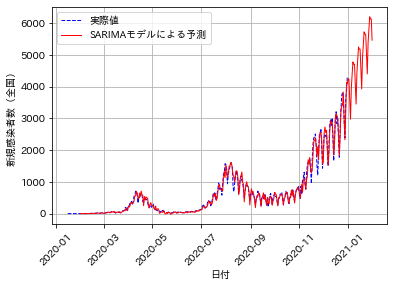

In [23]:
plt.plot(new_df, color='blue',  linestyle='dashed', linewidth = 1.0, label='実際値')
plt.plot(SARIMA_pred, color='red', linewidth = 1.0, label='SARIMAモデルによる予測')
plt.xlabel('日付')
plt.ylabel('新規感染者数（全国）')
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.savefig('figure/SARIMAestNEW.pdf', bbox_inches='tight')
plt.show()

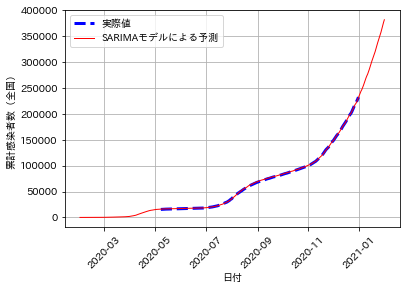

In [24]:
SARIMA_cml = pd.DataFrame(SARIMA_pred)
SARIMA_cml['cmlsum'] = pd.DataFrame.cumsum(SARIMA_cml['predicted_mean'])

plt.plot(cml_df['infected'], color='blue',  linestyle='dashed', linewidth = 3.0, label='実際値')
plt.plot(SARIMA_cml['cmlsum'], color='red',  linestyle='solid', linewidth = 1.0, label='SARIMAモデルによる予測')
plt.xlabel('日付')
plt.ylabel('累計感染者数（全国）')
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.savefig('figure/SARIMAestCML.pdf', bbox_inches='tight')
plt.show()

---------------

## SIRモデルとSARIMAモデルの比較

In [25]:
cml_df_oct = cml_df['2020-05-08':'2020-10-31']

initN = 126500000
initI = cml_df_oct.at[cml_df_oct.index[0], 'infected']
initR = cml_df_oct.at[cml_df_oct.index[0], 'removed']
initial_conditions = [initI, initR, initN]

period = cml_df_oct.index[-1]-cml_df_oct.index[0]
days = period.days
tspan = np.arange(0, days+1)

data = cml_df_oct[['infected','removed']].values

params = Parameters()
params.add('beta', value=beta, min=0, max=10)
params.add('gamma', value=gamma, min=0, max=10)
params['beta'].value = 0.1
params['gamma'].value = 0.01

result = minimize(error, params, args=(initial_conditions, tspan, data))

beta, gamma = result.params['beta'].value, result.params['gamma'].value
tspan = np.arange(0, days+31)
SIR_NOV_cml = odeint(SIR_model, [initS, initI, initR], tspan, args=(beta, gamma))
SIR_NOV_cml = pd.DataFrame(SIR_NOV_cml)
SIR_NOV_cml = SIR_NOV_cml.iloc[SIR_NOV_cml.index[-30]:SIR_NOV_cml.index[-1]+1]
SIR_NOV_cml['Date'] = pd.date_range('2020-11-01','2020-11-30')
SIR_NOV_cml = SIR_NOV_cml.set_index('Date')
SIR_NOV_cml = SIR_NOV_cml[1]
SIR_NOV_cml

Date
2020-11-01    112840.692312
2020-11-02    114112.172152
2020-11-03    115397.922983
2020-11-04    116698.103715
2020-11-05    118012.874994
2020-11-06    119342.399227
2020-11-07    120686.840600
2020-11-08    122046.365095
2020-11-09    123421.140509
2020-11-10    124811.336473
2020-11-11    126217.124472
2020-11-12    127638.677866
2020-11-13    129076.171904
2020-11-14    130529.783752
2020-11-15    131999.692507
2020-11-16    133486.079219
2020-11-17    134989.126913
2020-11-18    136509.020607
2020-11-19    138045.947337
2020-11-20    139600.096172
2020-11-21    141171.658242
2020-11-22    142760.826753
2020-11-23    144367.797013
2020-11-24    145992.766453
2020-11-25    147635.934647
2020-11-26    149297.503337
2020-11-27    150977.676454
2020-11-28    152676.660142
2020-11-29    154394.662779
2020-11-30    156131.895001
Name: 1, dtype: float64

In [26]:
new_df_oct = new_df['2020-05-08':'2020-10-31']

num = 0
for p in range(1, max_p + 1):
    for d in range(0, max_d + 1):
        for q in range(0, max_q + 1):
            for sp in range(0, max_sp + 1):
                for sd in range(0, max_sd + 1):
                    for sq in range(0, max_sq + 1):
                        sarima = sm.tsa.SARIMAX(new_df_oct, order=(p,d,q), seasonal_order=(sp,sd,sq,7), enforce_stationarity = True, enforce_invertibility = True).fit(method='bfgs', maxiter=300, disp=False)
                        modelSelection.iloc[num]["model"] = "order=(" + str(p) + ","+ str(d) + ","+ str(q) + "), season=("+ str(sp) + ","+ str(sd) + "," + str(sq) + ")"
                        modelSelection.iloc[num]["aic"] = sarima.aic
                        num = num + 1
                        
modelSelection[modelSelection.aic == min(modelSelection.aic)]

,model,aic
107,"order=(2,1,1), season=(0,1,1)",2036.43


In [27]:
bestSARIMA = sm.tsa.SARIMAX(new_df_oct, order=(2,1,1), seasonal_order=(0,1,1,7), enforce_stationarity = True, enforce_invertibility = True).fit()
SARIMA_NOV_new = bestSARIMA.predict('2020-11-01', '2020-11-30')

SARIMA_NOV_cml = pd.DataFrame(SARIMA_NOV_new)
SARIMA_NOV_cml['cmlsum'] = pd.DataFrame.cumsum(SARIMA_NOV_cml['predicted_mean']) + cml_df_oct.iat[-1, 0]

In [28]:
y_true = cml_df.loc['2020-11-01':'2020-11-30', 'infected']
y_SIR = SIR_NOV_cml
y_SARIMA = SARIMA_NOV_cml['cmlsum']

print('SIRモデルの平均二乗誤差(MSE): {}'.format(mean_squared_error(y_true, y_SIR)))
print('SARIMAモデルの平均二乗誤差(MSE): {}'.format(mean_squared_error(y_true, y_SARIMA)))

SIRモデルの平均二乗誤差(MSE): 185928778.73705834
SARIMAモデルの平均二乗誤差(MSE): 89232819.88699546


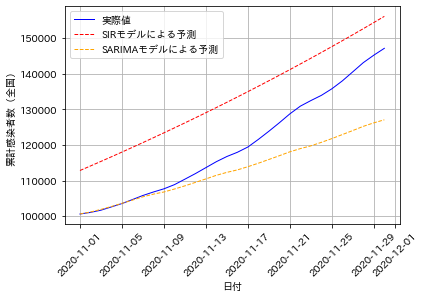

In [29]:
plt.plot(y_true, color='blue',  linestyle='solid', linewidth = 1.0, label='実際値')
plt.plot(y_SIR, color='red',  linestyle='dashed', linewidth = 1.0, label='SIRモデルによる予測')
plt.plot(y_SARIMA, color='orange',  linestyle='dashed', linewidth = 1.0, label='SARIMAモデルによる予測')
plt.xlabel('日付')
plt.ylabel('累計感染者数（全国）')
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.savefig('figure/NOVest.pdf', bbox_inches='tight')
plt.show()

---------------------------------------------------

## 外出自粛と感染率の関係

### 被説明変数と説明変数の準備

In [30]:
df = cml_df
df['inf+1d'] = df['infected'].shift(-1)
df['rem+1d'] = df['removed'].shift(-1)
df = df.dropna(how='any')
df['beta_t'] = ((df['inf+1d']-df['infected'])+(df['rem+1d']-df['removed']))/df['infected']
df['gamma_t'] = (df['rem+1d']-df['removed'])/df['infected']
df['R_t'] = df['beta_t']/df['gamma_t']
df = df.drop(columns=['inf+1d','rem+1d'])
print(df)

            infected   removed    beta_t   gamma_t       R_t
date                                                        
2020-05-08   15462.0    8710.0  0.019273  0.011577  1.664804
2020-05-09   15581.0    8889.0  0.018933  0.015788  1.199187
2020-05-10   15630.0    9135.0  0.031158  0.026296  1.184915
2020-05-11   15706.0    9546.0  0.071374  0.061951  1.152107
2020-05-12   15854.0   10519.0  0.034250  0.030844  1.110429
...              ...       ...       ...       ...       ...
2020-12-26  215461.0  184094.0  0.023285  0.009765  2.384506
2020-12-27  218374.0  186198.0  0.023822  0.010670  2.232618
2020-12-28  221246.0  188528.0  0.027250  0.011566  2.355998
2020-12-29  224716.0  191087.0  0.025468  0.008994  2.831766
2020-12-30  228418.0  193108.0  0.027918  0.010069  2.772609

[237 rows x 5 columns]


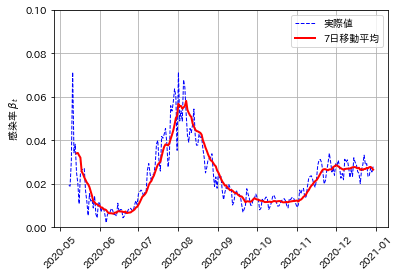

In [31]:
rolmean = df['beta_t'].rolling(window = 7).mean()
plt.plot(df['beta_t'], color='blue',  linestyle='dashed', linewidth = 1.0, label='実際値')
plt.plot(rolmean, color='red',  linestyle='solid', linewidth = 2.0, label='7日移動平均')
plt.ylabel(r'感染率 $\beta_t$')
plt.ylim(0, 0.1)
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.savefig('figure/betatRolling.pdf', bbox_inches="tight")
plt.show()

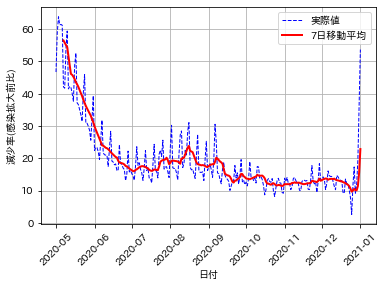

In [32]:
mobaku = pd.read_csv('https://mobaku.jp/covid-19/download/%E5%A2%97%E6%B8%9B%E7%8E%87%E4%B8%80%E8%A6%A7.csv', encoding="SHIFT-JIS", index_col='エリア')
mobaku['percentage'] = mobaku['各日15時時点増減率(%)']
mobaku = mobaku.query('percentage == "感染拡大前比"')
mobaku = mobaku.drop(columns=['メッシュ','各日15時時点増減率(%)','percentage']).T
mobaku.index = pd.to_datetime(mobaku.index)

mobaku['average'] = mobaku.mean(axis='columns')
mobaku['inv_avg'] = -mobaku['average']

rolmean = mobaku['inv_avg'].rolling(window = 7).mean()
plt.plot(mobaku['inv_avg'], color='blue',  linestyle='dashed', linewidth = 1.0, label='実際値')
plt.plot(rolmean, color='red',  linestyle='solid', linewidth = 2.0, label='7日移動平均')
plt.xlabel('日付')
plt.ylabel('減少率(感染拡大前比)')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.savefig('figure/MobakuRolling.pdf', bbox_inches="tight")
plt.show()

### 1日ずつシフトさせた回帰分析

In [33]:
data = df[['beta_t','gamma_t']]
data['inv_mobi'] = mobaku['inv_avg']
data = data.dropna(how='any')

result = pd.DataFrame(columns=['coef','lower','upper','f_pvalue','std_err'], index=np.arange(0,29))
for i in range(29):
    x = 0
    y = 0
    
    x = data[['inv_mobi']]
    x = sm.add_constant(x)
    y = data['beta_t'].shift(-i)
    
    OLS = sm.OLS(y, x, missing='drop').fit()
    coef = OLS.params['inv_mobi']
    lower = OLS.conf_int().iat[1, 0]
    upper = OLS.conf_int().iat[1, 1]
    f_pvalue = OLS.f_pvalue
    std_err = OLS.bse['inv_mobi']
    
    result.at[i,'coef'] = coef
    result.at[i,'lower'] = lower
    result.at[i,'upper'] = upper
    result.at[i,'f_pvalue'] = f_pvalue
    result.at[i,'std_err'] = std_err

result['coef'] = result['coef'].astype(float)
result['lower'] = result['lower'].astype(float)
result['upper'] = result['upper'].astype(float)
result['f_pvalue'] = result['f_pvalue'].astype(float)
result['std_err'] = result['std_err'].astype(float)

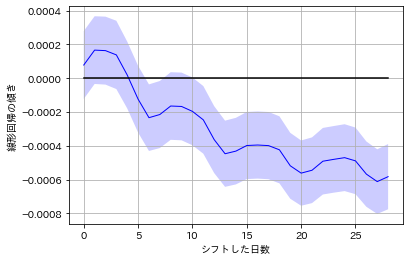

In [34]:
zero_line = np.full(29,0)
tspan = np.arange(0,29)
plt.plot(result['coef'], c='blue', linestyle='solid', linewidth = 1.0)
plt.plot(zero_line, c='black')
plt.fill_between(tspan, result['lower'], result['upper'], facecolor='blue',alpha=0.2)
plt.xlabel('シフトした日数')
plt.ylabel('線形回帰の傾き')
plt.grid()
plt.savefig('figure/ShiftedBeta.pdf', bbox_inches="tight")
plt.show()

### 回帰分析の結果とシミュレーション

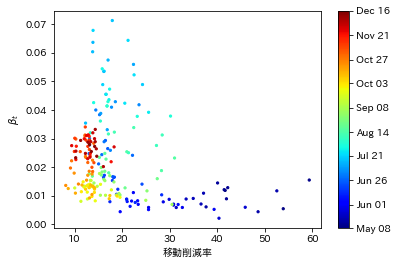

In [35]:
dt = data
dt['beta'] = dt['beta_t'].shift(-14)
dt['gamma'] = dt['gamma_t'].shift(-14)
dt = dt.dropna(how='any')

x = dt[['inv_mobi']]
y = dt[['beta']]

N_TICKS = 10
smap = plt.scatter(x, y, s=5, c=dt.index, cmap=cm.jet)
indexes = [dt.index[i] for i in np.linspace(0,dt.shape[0]-1,N_TICKS).astype(int)] 
cb = plt.colorbar(smap, orientation='vertical',ticks= dt.loc[indexes].index.astype(int))
cb.ax.set_yticklabels([index.strftime('%b %d') for index in indexes])
plt.xlabel('移動削減率')
plt.ylabel(r'$\beta_{t}$')
plt.savefig('figure/ScatterMobiBeta.pdf', bbox_inches="tight")
plt.show()

In [36]:
X = sm.add_constant(x)
print(sm.OLS(y,X).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                   beta   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.073
Method:                 Least Squares   F-statistic:                     18.59
Date:                Fri, 01 Jan 2021   Prob (F-statistic):           2.44e-05
Time:                        19:49:05   Log-Likelihood:                 650.37
No. Observations:                 223   AIC:                            -1297.
Df Residuals:                     221   BIC:                            -1290.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0301      0.002     14.605      0.0

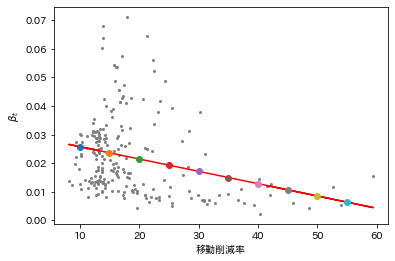

In [37]:
model_lr = LinearRegression()
model_lr.fit(x, y)

beta_1 = np.full(10,model_lr.coef_[0][0])
beta_0 = np.full(10,model_lr.intercept_[0])

mobi = np.arange(10,60,5)
beta_hat = np.around(beta_1*mobi+beta_0, 5)
test = pd.DataFrame(mobi, columns = ['mobi'])
test['beta_hat'] = beta_hat

plt.plot(x, y, 'o', c='gray', markersize=2)
plt.plot(x, model_lr.predict(x), c='red', linestyle="solid")
cmap = plt.get_cmap("tab10")
for i in range(len(mobi)):
    plt.plot(test['mobi'].iat[i], test['beta_hat'].iat[i],'o', c=cmap(i), markersize=6)
plt.xlabel('移動削減率')
plt.ylabel(r'$\beta_{t}$') 
plt.savefig('figure/LinReg.pdf', bbox_inches="tight")
plt.show()

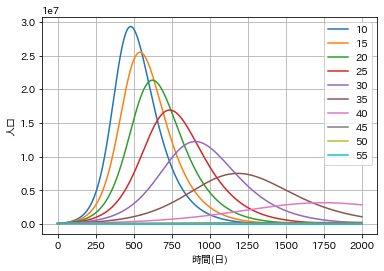

In [38]:
tspan = np.arange(0, 2000)
initI, initR, initN = 100000, 100000, 120000000
initS = initN - (initI + initR)
gamma = 0.01

res = pd.DataFrame()
for beta in test['beta_hat']:
    ode = odeint(SIR_model, [initS, initI, initR], tspan, args=(beta, gamma))
    ode_df = pd.DataFrame(ode)
    res[str(beta)]=ode_df.iloc[::,1]

plt.plot(tspan, res)
plt.legend(mobi)  
plt.xlabel('時間(日)')
plt.ylabel('人口')
plt.grid()
plt.savefig('figure/BetaSimulation.pdf', bbox_inches="tight")
plt.show()

### 医療の逼迫度の計算

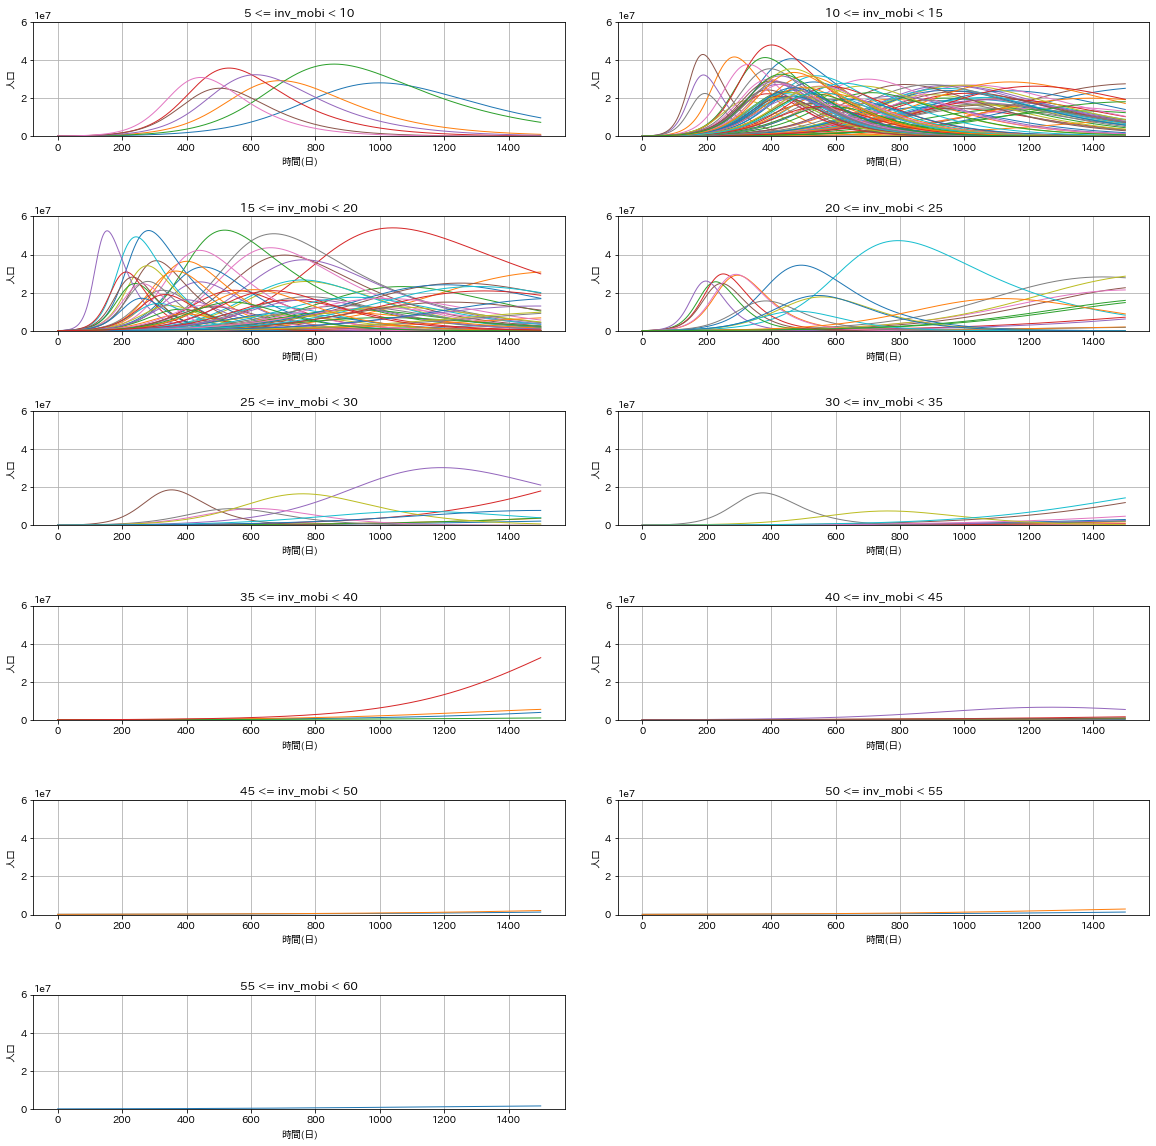

In [39]:
group = ['5 <= inv_mobi < 10', '10 <= inv_mobi < 15',
         '15 <= inv_mobi < 20', '20 <= inv_mobi < 25',
         '25 <= inv_mobi < 30', '30 <= inv_mobi < 35',
         '35 <= inv_mobi < 40', '40 <= inv_mobi < 45',
         '45 <= inv_mobi < 50', '50 <= inv_mobi < 55',
         '55 <= inv_mobi < 60']

tspan = np.arange(0, 1500)
initI, initR, initN = 100000, 100000, 120000000
initS = initN - (initI + initR)

fig = plt.figure(figsize=(20,20))

for i in range(11):
    ax = fig.add_subplot(6, 2, i+1)
    
    grp = group[i]
    sub = dt.query(grp)
    subdf = pd.DataFrame(sub[['beta','gamma']].values, columns = ['beta','gamma'])
    res = pd.DataFrame()
    
    for beta in subdf['beta']: 
        ode = odeint(SIR_model, [initS, initI, initR], tspan, args=(beta, subdf[subdf['beta'] == beta].gamma))
        ode_df = pd.DataFrame(ode)
        res[str(beta)]=ode_df.iloc[::,1]
        
    ax.plot(tspan, res, lw=1)
    ax.set_ylim([0, 6e+7])
    ax.set_title(grp)
    ax.set_xlabel('時間(日)')
    ax.set_ylabel('人口')
    ax.grid()

plt.subplots_adjust(wspace=0.1, hspace=0.7)
plt.savefig('figure/BetaGrouped.pdf', bbox_inches="tight")
plt.show()

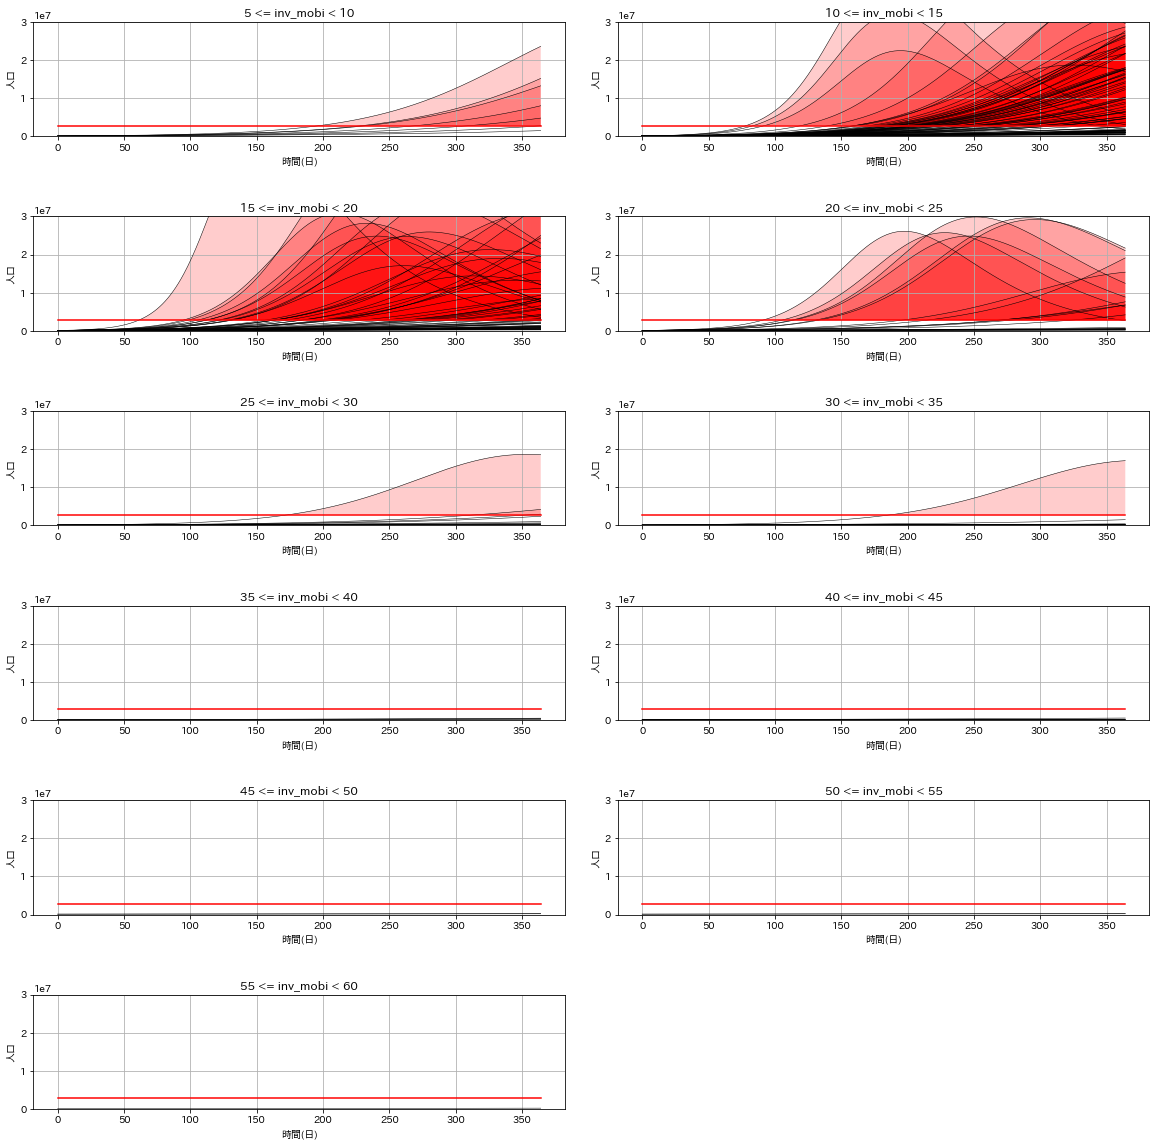

In [40]:
tspan = np.arange(0, 365)
initI, initR, initN = 100000, 100000, 120000000
initS = initN - (initI + initR)

fig = plt.figure(figsize=(20,20))

for i in range(11):
    ax = fig.add_subplot(6, 2, i+1)
    
    grp = group[i]
    sub = dt.query(grp)
    subdf = pd.DataFrame(sub[['beta','gamma']].values, columns = ['beta','gamma'])
    res = pd.DataFrame()
    
    limit = np.full(365, 0.28e+7)
    for beta in subdf['beta']: 
        ode = odeint(SIR_model, [initS, initI, initR], tspan, args=(beta, subdf[subdf['beta'] == beta].gamma))
        ode_df = pd.DataFrame(ode)
        res[str(beta)]=ode_df.iloc[::,1]
        ax.plot(tspan, res[str(beta)], c='k',lw=0.5)
        ax.fill_between(tspan,res[str(beta)],limit,where=res[str(beta)]>limit,facecolor='r',alpha=0.2)
    
    ax.plot(limit, c='r')
    ax.set_ylim([0, 3e+7])
    ax.set_title(grp)
    ax.set_xlabel('時間(日)')
    ax.set_ylabel('人口')
    ax.grid()
    
plt.subplots_adjust(wspace=0.1, hspace=0.7)
plt.savefig('figure/BetaArea.pdf', bbox_inches="tight")
plt.show()

In [41]:
tspan = np.arange(0, 365)
initI, initR, initN = 100000, 100000, 120000000
initS = initN - (initI + initR)

res = pd.DataFrame({'Average Exceed Area': ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0'],},
                  index=group)

for i in group:
    sub = dt.query(i)
    subdf = pd.DataFrame(sub[['beta','gamma']].values, columns = ['beta','gamma'])
    limit = 0.28e+07
    
    summ = 0
    count = 0
    for beta in subdf['beta']: 
        ode = odeint(SIR_model, [initS, initI, initR], tspan, args=(beta, subdf[subdf['beta'] == beta].gamma))
        infected = ode[:, 1]
        
        count = count + 1
        diff = 0
        for j in infected:
            if j > limit:
                diff = diff + (j - limit)
        summ = summ + diff
        
    final = summ / count
    print("{} ... datapoints : {}, Average exceed area : {:.3f}".format(i, count, final))
    res.loc[i] = final

5 <= inv_mobi < 10 ... datapoints : 7, Average exceed area : 409065055.726
10 <= inv_mobi < 15 ... datapoints : 93, Average exceed area : 760010117.660
15 <= inv_mobi < 20 ... datapoints : 64, Average exceed area : 1124106488.888
20 <= inv_mobi < 25 ... datapoints : 23, Average exceed area : 1027277553.967
25 <= inv_mobi < 30 ... datapoints : 11, Average exceed area : 153910688.511
30 <= inv_mobi < 35 ... datapoints : 10, Average exceed area : 126697578.372
35 <= inv_mobi < 40 ... datapoints : 4, Average exceed area : 0.000
40 <= inv_mobi < 45 ... datapoints : 6, Average exceed area : 0.000
45 <= inv_mobi < 50 ... datapoints : 2, Average exceed area : 0.000
50 <= inv_mobi < 55 ... datapoints : 2, Average exceed area : 0.000
55 <= inv_mobi < 60 ... datapoints : 1, Average exceed area : 0.000


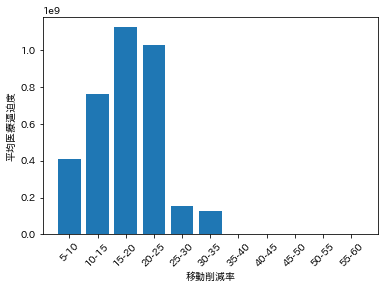

In [42]:
label = ['5-10', '10-15', '15-20', '20-25', '25-30', '30-35', '35-40', '40-45', '45-50', '50-55', '55-60']
plt.bar(label, res.iloc[::,0].values.astype(np.float), align="center")
plt.xlabel('移動削減率')
plt.ylabel('平均医療逼迫度')
plt.xticks(rotation=45)
plt.savefig('figure/ExceedArea.pdf', bbox_inches="tight")
plt.show()

---------------------

## 都道府県別の分析

In [43]:
big_city_j = ['東京','大阪','愛知','福岡','北海道']
big_city_e = ['Tokyo','Osaka','Aichi','Fukuoka','Hokkaido']
policy = pd.DataFrame(index=big_city_e, columns=['sch_s','sch_e','lock_s','lock_e'])

policy.loc['Tokyo'] = ['2020-3-2','2020-6-29','2020-4-7','2020-5-25']
policy.loc['Osaka'] = ['2020-3-2','2020-6-14','2020-4-7','2020-5-21']
policy.loc['Aichi'] = ['2020-3-2','2020-6-1','2020-4-16','2020-5-14']
policy.loc['Fukuoka'] = ['2020-3-2','2020-6-1','2020-4-7','2020-5-14']
policy.loc['Hokkaido'] = ['2020-2-27','2020-6-1','2020-4-16','2020-5-25']

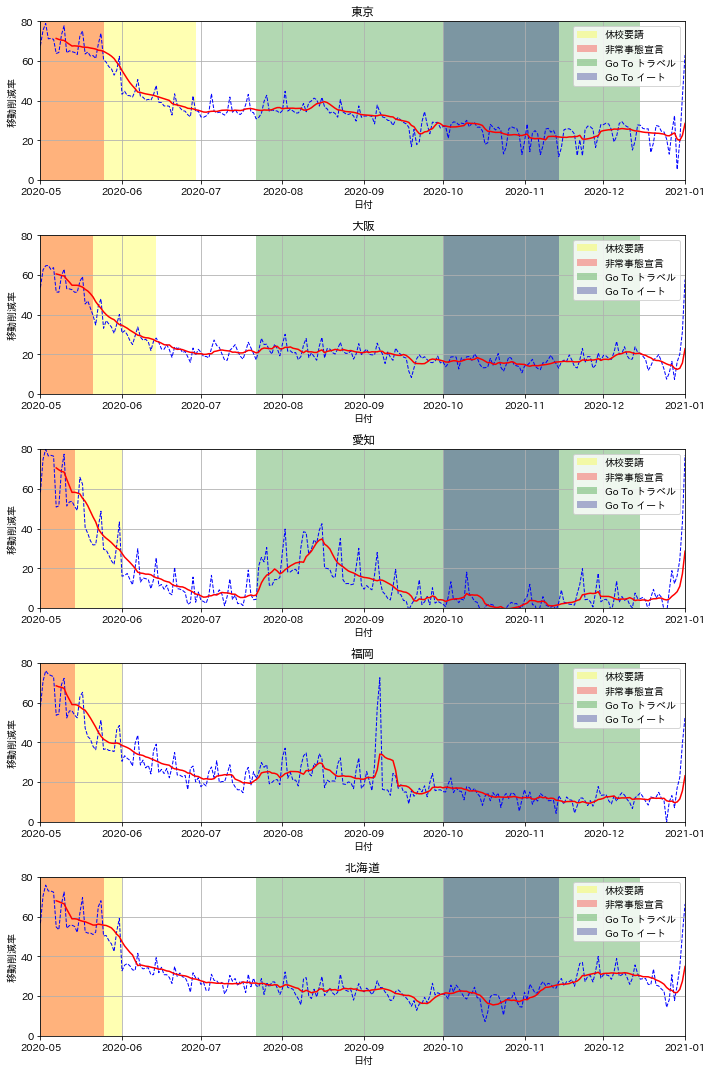

In [44]:
fig = plt.figure(figsize=(10,15))

for i in range(5):
    ax = fig.add_subplot(5, 1, i+1)
    city_e = big_city_e[i]
    city_j = big_city_j[i]
    
    subset = mobaku.loc[:, mobaku.columns.str.contains(city_j)]
    mobility = -subset.mean(axis=1)
    
    ax.plot(mobility, c='blue',linestyle='dashed', lw=1)
    ax.plot(mobility.rolling(window = 7).mean(), c='r', linestyle='solid', lw=1.5)
    
    ax.axvspan(pd.to_datetime(policy.at[city_e,'sch_s']), pd.to_datetime(policy.at[city_e,'sch_e']),facecolor='yellow',alpha=0.3, label='休校要請')
    ax.axvspan(pd.to_datetime(policy.at[city_e,'lock_s']), pd.to_datetime(policy.at[city_e,'lock_e']),facecolor='r',alpha=0.3, label='非常事態宣言')
    ax.axvspan(pd.to_datetime('2020-7-22'), pd.to_datetime('2020-12-15'),facecolor='green',alpha=0.3, label='Go To トラベル')
    ax.axvspan(pd.to_datetime('2020-10-01'), pd.to_datetime('2020-11-14'),facecolor='navy',alpha=0.3, label='Go To イート')
    
    ax.set_xlim([mobility.index[0], mobility.index[-1]])
    ax.set_ylim([0, 80])
    ax.legend(loc=1)
    ax.set_title(city_j)
    ax.set_xlabel('日付')
    ax.set_ylabel('移動削減率')
    ax.grid()
    
plt.tight_layout()
plt.savefig('figure/prefmobility.pdf', bbox_inches="tight")
plt.show()

---------------

In [45]:
data = df[['beta_t','gamma_t']]
data['inv_mobi'] = mobaku['inv_avg']
data = data.dropna(how='any')

result = pd.DataFrame(columns=['coef','lower','upper','f_pvalue','std_err'], index=np.arange(0,29))
for i in range(29):
    x = 0
    y = 0
    
    x = data[['inv_mobi']]
    x = sm.add_constant(x)
    y = data['beta_t'].shift(-i)
    
    OLS = sm.OLS(y, x, missing='drop').fit()
    coef = OLS.params['inv_mobi']
    lower = OLS.conf_int().iat[1, 0]
    upper = OLS.conf_int().iat[1, 1]
    f_pvalue = OLS.f_pvalue
    std_err = OLS.bse['inv_mobi']
    
    result.at[i,'coef'] = coef
    result.at[i,'lower'] = lower
    result.at[i,'upper'] = upper
    result.at[i,'f_pvalue'] = f_pvalue
    result.at[i,'std_err'] = std_err

result['coef'] = result['coef'].astype(float)
result['lower'] = result['lower'].astype(float)
result['upper'] = result['upper'].astype(float)
result['f_pvalue'] = result['f_pvalue'].astype(float)
result['std_err'] = result['std_err'].astype(float)

result

,coef,lower,upper,f_pvalue,std_err
0,0.000078,-0.000123,0.000279,4.438682e-01,0.000102
1,0.000167,-0.000034,0.000367,1.029842e-01,0.000102
2,0.000164,-0.000038,0.000365,1.106175e-01,0.000102
3,0.000138,-0.000064,0.000341,1.793384e-01,0.000103
4,0.000019,-0.000179,0.000217,8.494992e-01,0.000101
5,-0.000124,-0.000322,0.000074,2.181907e-01,0.000100
6,-0.000234,-0.000431,-0.000036,2.047353e-02,0.000100
7,-0.000215,-0.000414,-0.000016,3.411205e-02,0.000101
8,-0.000165,-0.000365,0.000036,1.069793e-01,0.000102
9,-0.000167,-0.000368,0.000033,1.020417e-01,0.000102


In [46]:
world_data

,continent,location,total_cases,new_cases,total_deaths,new_deaths
date,,,,,,
2020-02-24,Asia,Afghanistan,1.0,1.0,NaN,NaN
2020-02-25,Asia,Afghanistan,1.0,0.0,NaN,NaN
2020-02-26,Asia,Afghanistan,1.0,0.0,NaN,NaN
2020-02-27,Asia,Afghanistan,1.0,0.0,NaN,NaN
2020-02-28,Asia,Afghanistan,1.0,0.0,NaN,NaN
...,...,...,...,...,...,...
2020-12-27,Africa,Zimbabwe,13077.0,114.0,349.0,8.0
2020-12-28,Africa,Zimbabwe,13148.0,71.0,354.0,5.0
2020-12-29,Africa,Zimbabwe,13325.0,177.0,359.0,5.0


In [47]:
res_n_deaths

,new_deaths
2020-01-01,0
2020-01-02,0
2020-01-03,0
2020-01-04,0
2020-01-05,0
...,...
2020-12-27,14466
2020-12-28,18870
2020-12-29,31050
2020-12-30,30186


In [48]:
japan_data

,npatients,adpatients
date,,
2020-04-21,11350.0,370.0
2020-04-22,11772.0,420.0
2020-04-23,12240.0,434.0
2020-04-24,12681.0,423.0
2020-04-25,13031.0,346.0
...,...,...
2020-12-27,218374.0,2939.0
2020-12-28,221246.0,2383.0
2020-12-29,224716.0,3595.0
